<a href="https://colab.research.google.com/github/open-mmlab/mmaction2/blob/master/demo/mmaction2_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install some optional requirements
# !pip install -r requirements/optional.txt

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import sys
sys.path.append('/home/actrec/.local/lib/python3.6/site-packages/decord-0.5.3-py3.6-linux-x86_64.egg')
import decord
import pickle

1.7.0+cu110 True
0.12.0
11.0
GCC 7.5


In [4]:
cd ..

/home/actrec/.virtualenvs/mmaction/mmaction2


In [1]:
ls

checkpoints/  demo/        LICENSE              README.md         setup.cfg
childact-mm/  docker/      mmaction/            README_zh-CN.md   setup.py
configs/      docs/        mmaction2.egg-info/  requirements/     tests/
data/         docs_zh_CN/  my-mmaction.ipynb    requirements.txt  tools/


# TSN 94.44% 

In [25]:
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/   .pth \
#       -O checkpoints/db3c461.pth

--2021-03-22 01:46:07--  https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics600_rgb/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99220779 (95M) [application/octet-stream]
Saving to: ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’

checkpoints/tsn_r50 100%[===================>]  94,62M  10,5MB/s    in 11s     

2021-03-22 01:46:22 (8,61 MB/s) - ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’ saved [99220779/99220779]



In [6]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py')

In [7]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './childact-checkpoints/childact-tsn/epoch_30.pth'
cfg.resume_from = './childact-checkpoints/childact-tsn/epoch_30.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-tsn-2/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 32
cfg.optimizer.lr = 0.0001
# cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 40

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 20
cfg.evaluation.interval = 2
# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNet',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False),
    cls_head=dict(
        type='TSNHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.4,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips=None))
optimizer = dict(type='SGD', lr=0.0001, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=40, norm_type=2))
lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 0.0001),
    cyclic_times=1,
    step_ratio_up=0.4)
total_epochs = 40
checkpoint_config = dict(interval=2)
log_config = dict(interval=20, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './childact-checkpoints/childact-tsn/epoch_30.pth'
resume_from = './childact-checkpoints/childact

### Train a new recognizer

Finally, lets initialize the dataset and recognizer, then train a new recognizer!

In [8]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-25 14:12:39,300 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias'}


Use load_from_torchvision loader


2021-03-25 14:12:39,359 - mmaction - INFO - load checkpoint from ./childact-checkpoints/childact-tsn/epoch_30.pth
2021-03-25 14:12:39,360 - mmaction - INFO - Use load_from_local loader
2021-03-25 14:12:39,874 - mmaction - INFO - resumed epoch 30, iter 1155
2021-03-25 14:12:39,875 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-tsn-2
2021-03-25 14:12:39,876 - mmaction - INFO - workflow: [('train', 1)], max: 40 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
2021-03-25 14:15:28,124 - mmaction - INFO - Epoch [31][20/33]	lr: 4.077e-04, eta: 0:20:19, time: 8.412, data_time: 7.526, memory: 21540, top1_acc: 0.9422, top5_acc: 1.0000, loss_cls: 0.1803, loss: 0.1803, grad_norm: 3.5818
2021-03-25 14:20:14,028 - mmaction -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-25 14:22:39,733 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:22:39,735 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-25 14:22:39,736 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:22:39,738 - mmaction - INFO - 
mean_acc	0.8571
2021-03-25 14:22:40,001 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_32.pth.
2021-03-25 14:22:40,002 - mmaction - INFO - Best top1_acc is 0.8571 at 32 epoch.
2021-03-25 14:22:40,003 - mmaction - INFO - Epoch(val) [32][33]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-25 14:25:26,258 - mmaction - INFO - Epoch [33][20/33]	lr: 1.249e-04, eta: 0:07:44, time: 8.313, data_time: 7.438, memory: 21540, top1_acc: 0.9141, top5_acc: 1.0000, loss_cls: 0.2269, loss: 0.2269, grad_norm: 4.7388
2021-03-25 14:30:13,231 - mmaction - INFO - Epoch [34][20/33]	lr: 4.337e-05, eta: 0:04:21, time: 8.550, data_time: 7.676, memory: 21540, top1_acc: 0.9359, top5_acc: 0.9984, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-25 14:32:36,374 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:32:36,376 - mmaction - INFO - 
top1_acc	0.8651
top5_acc	1.0000
2021-03-25 14:32:36,376 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:32:36,378 - mmaction - INFO - 
mean_acc	0.8651
2021-03-25 14:32:36,670 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_34.pth.
2021-03-25 14:32:36,671 - mmaction - INFO - Best top1_acc is 0.8651 at 34 epoch.
2021-03-25 14:32:36,672 - mmaction - INFO - Epoch(val) [34][33]	top1_acc: 0.8651, top5_acc: 1.0000, mean_class_accuracy: 0.8651
2021-03-25 14:35:22,905 - mmaction - INFO - Epoch [35][20/33]	lr: 3.904e-06, eta: 0:01:12, time: 8.312, data_time: 7.438, memory: 21540, top1_acc: 0.8984, top5_acc: 0.9984, loss_cls: 0.2482, loss: 0.2482, grad_norm: 4.5644
2021-03-25 14:40:10,661 - mmaction - INFO - Epoch [36][20/33]	lr: 5.144e-04, eta: -1 day, 23:58:11, time: 8.546, data_time: 7.670, memory: 21540, top1_acc: 0.9000, top5_acc:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.6 task/s, elapsed: 35s, ETA:     0s

2021-03-25 14:42:33,137 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:42:33,139 - mmaction - INFO - 
top1_acc	0.8810
top5_acc	1.0000
2021-03-25 14:42:33,139 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:42:33,141 - mmaction - INFO - 
mean_acc	0.8810
2021-03-25 14:42:33,430 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_36.pth.
2021-03-25 14:42:33,431 - mmaction - INFO - Best top1_acc is 0.8810 at 36 epoch.
2021-03-25 14:42:33,431 - mmaction - INFO - Epoch(val) [36][33]	top1_acc: 0.8810, top5_acc: 1.0000, mean_class_accuracy: 0.8810
2021-03-25 14:45:18,239 - mmaction - INFO - Epoch [37][20/33]	lr: 6.068e-04, eta: -1 day, 23:55:14, time: 8.240, data_time: 7.367, memory: 21540, top1_acc: 0.9187, top5_acc: 1.0000, loss_cls: 0.2261, loss: 0.2261, grad_norm: 4.7761
2021-03-25 14:50:03,231 - mmaction - INFO - Epoch [38][20/33]	lr: 7.817e-04, eta: -1 day, 23:52:19, time: 8.473, data_time: 7.601, memory: 21540, top1_acc: 0.9125, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.6 task/s, elapsed: 35s, ETA:     0s

2021-03-25 14:52:34,766 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:52:34,767 - mmaction - INFO - 
top1_acc	0.8810
top5_acc	1.0000
2021-03-25 14:52:34,768 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:52:34,769 - mmaction - INFO - 
mean_acc	0.8810
2021-03-25 14:52:34,770 - mmaction - INFO - Epoch(val) [38][33]	top1_acc: 0.8810, top5_acc: 1.0000, mean_class_accuracy: 0.8810
2021-03-25 14:55:23,918 - mmaction - INFO - Epoch [39][20/33]	lr: 1.032e-03, eta: -1 day, 23:49:25, time: 8.457, data_time: 7.586, memory: 21540, top1_acc: 0.9187, top5_acc: 1.0000, loss_cls: 0.2099, loss: 0.2099, grad_norm: 5.1517
2021-03-25 15:00:04,888 - mmaction - INFO - Epoch [40][20/33]	lr: 1.349e-03, eta: -1 day, 23:46:33, time: 8.332, data_time: 7.458, memory: 21540, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.2583, loss: 0.2583, grad_norm: 4.9323
2021-03-25 15:02:03,446 - mmaction - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-25 15:02:39,524 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:02:39,526 - mmaction - INFO - 
top1_acc	0.8810
top5_acc	1.0000
2021-03-25 15:02:39,526 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:02:39,527 - mmaction - INFO - 
mean_acc	0.8810
2021-03-25 15:02:39,528 - mmaction - INFO - Epoch(val) [40][33]	top1_acc: 0.8810, top5_acc: 1.0000, mean_class_accuracy: 0.8810


In [9]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

## Test the trained recognizer

After finetuning the recognizer, let's check the prediction results!

In [10]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=16,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.2 task/s, elapsed: 56s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9444
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9444
top1_acc: 0.9444
top5_acc: 1.0000
mean_class_accuracy: 0.9444


<AxesSubplot:>

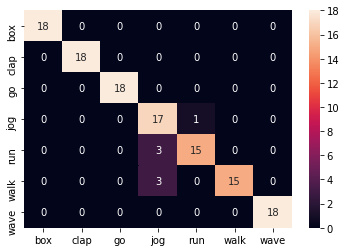

In [11]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# SlowFast 91.27%

In [2]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth \
      -O checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth

--2021-03-22 18:16:35--  https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138274276 (132M) [application/octet-stream]
Saving to: ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’

checkpoints/slowfas 100%[===================>] 131,87M  6,72MB/s    in 17s     

2021-03-22 18:16:55 (7,79 MB/s) - ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’ saved [138274276/138274276]



In [7]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb.py')

In [8]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './childact-checkpoints/childact-slowfast3/best_top1_acc_epoch_5.pth'
cfg.resume_from = './childact-checkpoints/childact-slowfast3/best_top1_acc_epoch_5.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-slowfast4/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 16
# cfg.data.workers_per_gpu = 4
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
cfg.optimizer.lr = 0.001

# cfg.lr_config = dict(
#     policy='cyclic',
#     target_ratio=(10, 1e-4),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )
cfg.total_epochs = 11
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)
cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dSlowFast',
        pretrained=None,
        resample_rate=8,
        speed_ratio=8,
        channel_ratio=8,
        slow_pathway=dict(
            type='resnet3d',
            depth=50,
            pretrained=None,
            lateral=True,
            conv1_kernel=(1, 7, 7),
            dilations=(1, 1, 1, 1),
            conv1_stride_t=1,
            pool1_stride_t=1,
            inflate=(0, 0, 1, 1),
            norm_eval=False),
        fast_pathway=dict(
            type='resnet3d',
            depth=50,
            pretrained=None,
            lateral=False,
            base_channels=8,
            conv1_kernel=(5, 7, 7),
            conv1_stride_t=1,
            pool1_stride_t=1,
            norm_eval=False)),
    cls_head=dict(
        type='SlowFastHead',
        in_channels=2304,
        num_classes=7,
        spatial_type='avg',
        dropout_ratio=0.5),
    train_cfg=None,
    test_cf

### Train a new recognizer

Finally, lets initialize the dataset and recognizer, then train a new recognizer!

In [9]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-25 12:40:03,663 - mmaction - INFO - load checkpoint from ./childact-checkpoints/childact-slowfast3/best_top1_acc_epoch_5.pth
2021-03-25 12:40:03,664 - mmaction - INFO - Use load_from_local loader
2021-03-25 12:40:03,874 - mmaction - INFO - resumed epoch 5, iter 330
2021-03-25 12:40:03,876 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-slowfast4
2021-03-25 12:40:03,877 - mmaction - INFO - workflow: [('train', 1)], max: 11 epochs
2021-03-25 12:41:36,333 - mmaction - INFO - Epoch [6][40/66]	lr: 1.416e-02, eta: 0:13:42, time: 2.311, data_time: 1.426, memory: 12207, top1_acc: 0.7500, top5_acc: 0.9844, loss_cls: 0.6193, loss: 0.6193, grad_norm: 0.9436
2021-03-25 12:42:28,631 - mmaction - INFO - Saving checkpoint at 6 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:42:48,742 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:42:48,743 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-25 12:42:48,744 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:42:48,744 - mmaction - INFO - 
mean_acc	0.8254
2021-03-25 12:42:49,135 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_6.pth.
2021-03-25 12:42:49,136 - mmaction - INFO - Best top1_acc is 0.8254 at 6 epoch.
2021-03-25 12:42:49,137 - mmaction - INFO - Epoch(val) [6][66]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-25 12:44:22,536 - mmaction - INFO - Epoch [7][40/66]	lr: 1.177e-02, eta: 0:08:28, time: 2.335, data_time: 1.443, memory: 12207, top1_acc: 0.6984, top5_acc: 0.9906, loss_cls: 0.7002, loss: 0.7002, grad_norm: 1.1397


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:45:38,793 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:45:38,795 - mmaction - INFO - 
top1_acc	0.7937
top5_acc	1.0000
2021-03-25 12:45:38,796 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:45:38,797 - mmaction - INFO - 
mean_acc	0.7937
2021-03-25 12:45:38,798 - mmaction - INFO - Epoch(val) [7][66]	top1_acc: 0.7937, top5_acc: 1.0000, mean_class_accuracy: 0.7937
2021-03-25 12:47:09,756 - mmaction - INFO - Epoch [8][40/66]	lr: 8.796e-03, eta: 0:06:00, time: 2.274, data_time: 1.378, memory: 12207, top1_acc: 0.7109, top5_acc: 0.9891, loss_cls: 0.7145, loss: 0.7145, grad_norm: 1.0675
2021-03-25 12:48:02,808 - mmaction - INFO - Saving checkpoint at 8 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.5 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:48:22,782 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:48:22,783 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-25 12:48:22,784 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:48:22,784 - mmaction - INFO - 
mean_acc	0.8492
2021-03-25 12:48:23,196 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_8.pth.
2021-03-25 12:48:23,197 - mmaction - INFO - Best top1_acc is 0.8492 at 8 epoch.
2021-03-25 12:48:23,198 - mmaction - INFO - Epoch(val) [8][66]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-25 12:49:56,477 - mmaction - INFO - Epoch [9][40/66]	lr: 5.650e-03, eta: 0:04:05, time: 2.332, data_time: 1.436, memory: 12207, top1_acc: 0.7219, top5_acc: 0.9875, loss_cls: 0.7207, loss: 0.7207, grad_norm: 1.1247


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:51:07,151 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:51:07,154 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-25 12:51:07,155 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:51:07,157 - mmaction - INFO - 
mean_acc	0.8254
2021-03-25 12:51:07,158 - mmaction - INFO - Epoch(val) [9][66]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-25 12:52:37,352 - mmaction - INFO - Epoch [10][40/66]	lr: 2.809e-03, eta: 0:02:19, time: 2.255, data_time: 1.360, memory: 12207, top1_acc: 0.7141, top5_acc: 0.9922, loss_cls: 0.6923, loss: 0.6923, grad_norm: 1.0608
2021-03-25 12:53:32,091 - mmaction - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.5 task/s, elapsed: 19s, ETA:     0s

2021-03-25 12:53:52,057 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:53:52,059 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-25 12:53:52,059 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:53:52,061 - mmaction - INFO - 
mean_acc	0.8492
2021-03-25 12:53:52,062 - mmaction - INFO - Epoch(val) [10][66]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-25 12:55:24,466 - mmaction - INFO - Epoch [11][40/66]	lr: 7.703e-04, eta: 0:00:38, time: 2.310, data_time: 1.412, memory: 12207, top1_acc: 0.6969, top5_acc: 0.9859, loss_cls: 0.7326, loss: 0.7326, grad_norm: 1.0574


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:56:38,924 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:56:38,926 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-03-25 12:56:38,926 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:56:38,928 - mmaction - INFO - 
mean_acc	0.8333
2021-03-25 12:56:38,928 - mmaction - INFO - Epoch(val) [11][66]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333


In [5]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
import gc
# gc.enable()
gc.collect()

0

In [10]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

## Test the trained recognizer

After finetuning the recognizer, let's check the prediction results!

In [11]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# checkpoint = './childact-checkpoints/childact-slowfast/best_top1_acc_epoch_50.pth'
# modelt = init_recognizer(cfg, checkpoint, device='cuda:0')
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=2,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.0 task/s, elapsed: 2773s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9365
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9365
top1_acc: 0.9365
top5_acc: 1.0000
mean_class_accuracy: 0.9365


<AxesSubplot:>

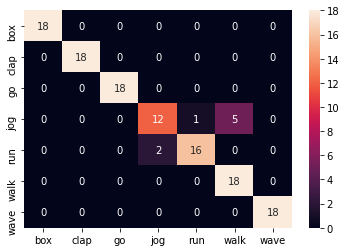

In [12]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# R(2+1)D 59.52%

In [6]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth \
      -O checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth

--2021-03-24 13:44:27--  https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255320099 (243M) [application/octet-stream]
Saving to: ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’

checkpoints/r2plus1 100%[===================>] 243,49M  6,98MB/s    in 32s     

2021-03-24 13:45:05 (7,72 MB/s) - ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’ saved [255320099/255320099]



In [17]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb.py')

In [18]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth'
# cfg.resume_from = './childact-checkpoints/childact-r2plus1d/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-r2plus1d-3'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 32
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 10

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
del cfg.model.backbone['norm_cfg']
# cfg.model.cls_head.type = "TSNHead"
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet2Plus1d',
        depth=34,
        pretrained=None,
        pretrained2d=False,
        norm_eval=False,
        conv_cfg=dict(type='Conv2plus1d'),
        conv1_kernel=(3, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(1, 1, 1, 1),
        spatial_strides=(1, 2, 2, 2),
        temporal_strides=(1, 2, 2, 2),
        zero_init_residual=False,
        act_cfg=dict(type='ReLU')),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=512,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=4)
log_config = dict(interval=10, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth'
resume_from = None

In [ ]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-25 15:30:20,791 - mmaction - INFO - load checkpoint from ./checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
2021-03-25 15:30:20,792 - mmaction - INFO - Use load_from_local loader
2021-03-25 15:30:20,949 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 512]) from checkpoint, the shape in current model is torch.Size([7, 512]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-25 15:30:20,956 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-r2plus1d-3
2021-03-25 15:30:20,956 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 15:39:57,043 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:39:57,045 - mmaction - INFO - 
top1_acc	0.3651
top5_acc	1.0000
2021-03-25 15:39:57,046 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:39:57,047 - mmaction - INFO - 
mean_acc	0.3651
2021-03-25 15:39:57,852 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-25 15:39:57,854 - mmaction - INFO - Best top1_acc is 0.3651 at 5 epoch.
2021-03-25 15:39:57,855 - mmaction - INFO - Epoch(val) [5][33]	top1_acc: 0.3651, top5_acc: 1.0000, mean_class_accuracy: 0.3651
2021-03-25 15:40:40,465 - mmaction - INFO - Epoch [6][10/33]	lr: 4.809e-01, eta: 1:21:13, time: 4.260, data_time: 2.969, memory: 21540, top1_acc: 0.3094, top5_acc: 0.9656, loss_cls: 1.5239, loss: 1.5239, grad_norm: 0.5280
2021-03-25 15:41:09,933 - mmaction - INFO - Epoch [6][20/33]	lr: 5.121e-01, eta: 1:20:17, time: 2.947, data_time: 1.667, memory: 21540, top1_acc: 0.3312, top5_acc: 0.9750, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 15:49:29,166 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:49:29,167 - mmaction - INFO - 
top1_acc	0.3175
top5_acc	0.9762
2021-03-25 15:49:29,168 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:49:29,168 - mmaction - INFO - 
mean_acc	0.3175
2021-03-25 15:49:29,169 - mmaction - INFO - Epoch(val) [10][33]	top1_acc: 0.3175, top5_acc: 0.9762, mean_class_accuracy: 0.3175
2021-03-25 15:50:15,748 - mmaction - INFO - Epoch [11][10/33]	lr: 1.111e+00, eta: 1:11:55, time: 4.658, data_time: 3.382, memory: 21540, top1_acc: 0.3438, top5_acc: 0.9625, loss_cls: 1.5662, loss: 1.5662, grad_norm: 0.5038
2021-03-25 15:50:44,778 - mmaction - INFO - Epoch [11][20/33]	lr: 1.152e+00, eta: 1:11:11, time: 2.903, data_time: 1.629, memory: 21540, top1_acc: 0.3219, top5_acc: 0.9563, loss_cls: 1.5483, loss: 1.5483, grad_norm: 0.5952
2021-03-25 15:51:14,411 - mmaction - INFO - Epoch [11][30/33]	lr: 1.194e+00, eta: 1:10:31, time: 2.963, data_time: 1.683, memory: 21540

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 15:58:57,064 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:58:57,066 - mmaction - INFO - 
top1_acc	0.1984
top5_acc	0.7460
2021-03-25 15:58:57,066 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:58:57,067 - mmaction - INFO - 
mean_acc	0.1984
2021-03-25 15:58:57,068 - mmaction - INFO - Epoch(val) [15][33]	top1_acc: 0.1984, top5_acc: 0.7460, mean_class_accuracy: 0.1984
2021-03-25 15:59:40,086 - mmaction - INFO - Epoch [16][10/33]	lr: 1.734e+00, eta: 1:02:45, time: 4.301, data_time: 3.018, memory: 21540, top1_acc: 0.2938, top5_acc: 0.9437, loss_cls: 1.6775, loss: 1.6775, grad_norm: 0.4904
2021-03-25 16:00:07,571 - mmaction - INFO - Epoch [16][20/33]	lr: 1.763e+00, eta: 1:02:02, time: 2.748, data_time: 1.469, memory: 21540, top1_acc: 0.3063, top5_acc: 0.9719, loss_cls: 1.6790, loss: 1.6790, grad_norm: 0.4985
2021-03-25 16:00:40,896 - mmaction - INFO - Epoch [16][30/33]	lr: 1.791e+00, eta: 1:01:34, time: 3.332, data_time: 2.050, memory: 21540

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 16:08:26,069 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 16:08:26,070 - mmaction - INFO - 
top1_acc	0.2381
top5_acc	1.0000
2021-03-25 16:08:26,071 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 16:08:26,072 - mmaction - INFO - 
mean_acc	0.2381
2021-03-25 16:08:26,073 - mmaction - INFO - Epoch(val) [20][33]	top1_acc: 0.2381, top5_acc: 1.0000, mean_class_accuracy: 0.2381
2021-03-25 16:09:08,179 - mmaction - INFO - Epoch [21][10/33]	lr: 2.000e+00, eta: 0:53:45, time: 4.210, data_time: 2.933, memory: 21540, top1_acc: 0.2875, top5_acc: 0.9437, loss_cls: 1.7203, loss: 1.7203, grad_norm: 0.4388
2021-03-25 16:09:35,054 - mmaction - INFO - Epoch [21][20/33]	lr: 2.000e+00, eta: 0:53:06, time: 2.687, data_time: 1.415, memory: 21540, top1_acc: 0.3156, top5_acc: 0.9187, loss_cls: 1.6964, loss: 1.6964, grad_norm: 0.4517
2021-03-25 16:10:09,760 - mmaction - INFO - Epoch [21][30/33]	lr: 1.999e+00, eta: 0:52:38, time: 3.471, data_time: 2.192, memory: 21540

In [30]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [34]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader, load_annotations, build_dataset
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.7 task/s, elapsed: 180s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5952
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.5952
top1_acc: 0.5952
top5_acc: 1.0000
mean_class_accuracy: 0.5952


<AxesSubplot:>

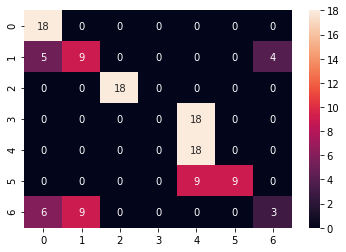

In [73]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True)

# TSM 93.65%

In [3]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tsm/tsm_r50_video_1x1x8_100e_kinetics400_rgb/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth \
      -O checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth

--2021-03-24 19:15:04--  https://download.openmmlab.com/mmaction/recognition/tsm/tsm_r50_video_1x1x8_100e_kinetics400_rgb/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97579687 (93M) [application/octet-stream]
Saving to: ‘checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth’

checkpoints/tsm_r50 100%[===================>]  93,06M  8,72MB/s    in 12s     

2021-03-24 19:15:20 (7,71 MB/s) - ‘checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth’ saved [97579687/97579687]



In [9]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsm/tsm_r50_video_1x1x8_50e_kinetics400_rgb.py')

In [10]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-tsm'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 25

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNetTSM',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False,
        shift_div=8),
    cls_head=dict(
        type='TSMHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.5,
        init_std=0.001,
        is_shift=True),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
optimizer = dict(
    type='SGD',
    constructor='TSMOptimizerConstructor',
    paramwise_cfg=dict(fc_lr5=True),
    lr=0.02,
    weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=20, norm_type=2))
lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 0.0001),
    cyclic_times=1,
    step_ratio_up=0.4)
total_epochs = 51
checkpoint_config = dict(interval=4)
log_config = dict(interval=25, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
l

In [11]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-24 21:03:31,550 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias'}


Use load_from_torchvision loader


2021-03-24 21:03:33,980 - mmaction - INFO - load checkpoint from checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth
2021-03-24 21:03:33,982 - mmaction - INFO - Use load_from_local loader
2021-03-24 21:03:34,081 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-24 21:03:34,086 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-tsm
2021-03-24 21:03:34,087 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 21:26:56,186 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 21:26:56,188 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-24 21:26:56,188 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 21:26:56,190 - mmaction - INFO - 
mean_acc	0.8016
2021-03-24 21:26:56,341 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-24 21:26:56,342 - mmaction - INFO - Best top1_acc is 0.8016 at 5 epoch.
2021-03-24 21:26:56,343 - mmaction - INFO - Epoch(val) [5][44]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-24 21:29:50,484 - mmaction - INFO - Epoch [6][25/44]	lr: 5.091e-02, eta: 2:18:31, time: 6.965, data_time: 5.991, memory: 20204, top1_acc: 0.8633, top5_acc: 0.9983, loss_cls: 0.3578, loss: 0.3578, grad_norm: 4.3697
2021-03-24 21:34:28,680 - mmaction - INFO - Epoch [7][25/44]	lr: 6.203e-02, eta: 2:15:02, time: 7.168, data_time: 6.192, memory: 20204, top1_acc: 0.8700, top5_acc: 0.9983, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 21:50:22,735 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 21:50:22,737 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-24 21:50:22,737 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 21:50:22,739 - mmaction - INFO - 
mean_acc	0.8492
2021-03-24 21:50:22,912 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-03-24 21:50:22,912 - mmaction - INFO - Best top1_acc is 0.8492 at 10 epoch.
2021-03-24 21:50:22,913 - mmaction - INFO - Epoch(val) [10][44]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-24 21:53:16,024 - mmaction - INFO - Epoch [11][25/44]	lr: 1.149e-01, eta: 1:59:43, time: 6.924, data_time: 5.948, memory: 20204, top1_acc: 0.8817, top5_acc: 1.0000, loss_cls: 0.3227, loss: 0.3227, grad_norm: 2.9154
2021-03-24 21:57:42,847 - mmaction - INFO - Epoch [12][25/44]	lr: 1.286e-01, eta: 1:56:20, time: 6.806, data_time: 5.830, memory: 20204, top1_acc: 0.8550, top5_acc: 0.9983, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 22:13:51,448 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 22:13:51,450 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 22:13:51,451 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 22:13:51,452 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 22:13:51,453 - mmaction - INFO - Epoch(val) [15][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 22:16:43,943 - mmaction - INFO - Epoch [16][25/44]	lr: 1.761e-01, eta: 1:43:45, time: 6.899, data_time: 5.905, memory: 20204, top1_acc: 0.8417, top5_acc: 1.0000, loss_cls: 0.3540, loss: 0.3540, grad_norm: 2.6687
2021-03-24 22:18:21,773 - mmaction - INFO - Saving checkpoint at 16 epochs
2021-03-24 22:21:12,732 - mmaction - INFO - Epoch [17][25/44]	lr: 1.847e-01, eta: 1:40:39, time: 6.831, data_time: 5.806, memory: 20204, top1_acc: 0.8600, top5_acc: 1.0000, loss_cls: 0.3870, loss: 0.3870, grad_norm: 3.2032
2021-03-24 22:25:49,296 - mmaction - INFO - Epoch [18][25/44

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 22:37:17,321 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 22:37:17,323 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 22:37:17,323 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 22:37:17,325 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 22:37:17,326 - mmaction - INFO - Epoch(val) [20][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 22:40:03,624 - mmaction - INFO - Epoch [21][25/44]	lr: 2.000e-01, eta: 1:28:33, time: 6.652, data_time: 5.674, memory: 20204, top1_acc: 0.8833, top5_acc: 1.0000, loss_cls: 0.2851, loss: 0.2851, grad_norm: 1.9111
2021-03-24 22:44:38,747 - mmaction - INFO - Epoch [22][25/44]	lr: 1.993e-01, eta: 1:25:35, time: 6.870, data_time: 5.893, memory: 20204, top1_acc: 0.8867, top5_acc: 1.0000, loss_cls: 0.2601, loss: 0.2601, grad_norm: 2.1638
2021-03-24 22:49:22,392 - mmaction - INFO - Epoch [23][25/44]	lr: 1.976e-01, eta: 1:22:50, time: 7.289, data_time: 6.287, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 23:00:59,644 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:00:59,647 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	1.0000
2021-03-24 23:00:59,648 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:00:59,651 - mmaction - INFO - 
mean_acc	0.8175
2021-03-24 23:00:59,652 - mmaction - INFO - Epoch(val) [25][44]	top1_acc: 0.8175, top5_acc: 1.0000, mean_class_accuracy: 0.8175
2021-03-24 23:03:51,401 - mmaction - INFO - Epoch [26][25/44]	lr: 1.863e-01, eta: 1:14:06, time: 6.870, data_time: 5.887, memory: 20204, top1_acc: 0.8933, top5_acc: 1.0000, loss_cls: 0.2764, loss: 0.2764, grad_norm: 2.1380
2021-03-24 23:08:27,656 - mmaction - INFO - Epoch [27][25/44]	lr: 1.807e-01, eta: 1:11:07, time: 6.820, data_time: 5.837, memory: 20204, top1_acc: 0.8933, top5_acc: 0.9983, loss_cls: 0.2690, loss: 0.2690, grad_norm: 2.0275
2021-03-24 23:12:53,090 - mmaction - INFO - Epoch [28][25/44]	lr: 1.742e-01, eta: 1:08:04, time: 6.593, data_time: 5.600, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-24 23:24:46,975 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:24:46,977 - mmaction - INFO - 
top1_acc	0.8730
top5_acc	1.0000
2021-03-24 23:24:46,977 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:24:46,979 - mmaction - INFO - 
mean_acc	0.8730
2021-03-24 23:24:47,130 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-03-24 23:24:47,131 - mmaction - INFO - Best top1_acc is 0.8730 at 30 epoch.
2021-03-24 23:24:47,132 - mmaction - INFO - Epoch(val) [30][44]	top1_acc: 0.8730, top5_acc: 1.0000, mean_class_accuracy: 0.8730
2021-03-24 23:27:36,817 - mmaction - INFO - Epoch [31][25/44]	lr: 1.504e-01, eta: 0:59:15, time: 6.787, data_time: 5.808, memory: 20204, top1_acc: 0.9150, top5_acc: 0.9983, loss_cls: 0.2196, loss: 0.2196, grad_norm: 1.8701
2021-03-24 23:32:14,860 - mmaction - INFO - Epoch [32][25/44]	lr: 1.413e-01, eta: 0:56:22, time: 7.025, data_time: 6.044, memory: 20204, top1_acc: 0.9217, top5_acc: 1.0000, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-24 23:48:22,662 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:48:22,664 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 23:48:22,665 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:48:22,667 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 23:48:22,668 - mmaction - INFO - Epoch(val) [35][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 23:51:14,376 - mmaction - INFO - Epoch [36][25/44]	lr: 1.015e-01, eta: 0:44:36, time: 6.868, data_time: 5.877, memory: 20204, top1_acc: 0.9167, top5_acc: 1.0000, loss_cls: 0.1841, loss: 0.1841, grad_norm: 2.0693
2021-03-24 23:52:51,813 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-03-24 23:55:40,270 - mmaction - INFO - Epoch [37][25/44]	lr: 9.127e-02, eta: 0:41:41, time: 6.732, data_time: 5.754, memory: 20204, top1_acc: 0.9533, top5_acc: 1.0000, loss_cls: 0.1247, loss: 0.1247, grad_norm: 1.3474
2021-03-25 00:00:14,754 - mmaction - INFO - Epoch [38][25/44

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-25 00:11:59,894 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 00:11:59,896 - mmaction - INFO - 
top1_acc	0.9206
top5_acc	1.0000
2021-03-25 00:11:59,897 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 00:11:59,898 - mmaction - INFO - 
mean_acc	0.9206
2021-03-25 00:12:00,066 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-25 00:12:00,067 - mmaction - INFO - Best top1_acc is 0.9206 at 40 epoch.
2021-03-25 00:12:00,068 - mmaction - INFO - Epoch(val) [40][44]	top1_acc: 0.9206, top5_acc: 1.0000, mean_class_accuracy: 0.9206
2021-03-25 00:15:02,371 - mmaction - INFO - Epoch [41][25/44]	lr: 5.224e-02, eta: 0:30:08, time: 7.292, data_time: 6.300, memory: 20204, top1_acc: 0.9417, top5_acc: 1.0000, loss_cls: 0.1471, loss: 0.1471, grad_norm: 1.4060
2021-03-25 00:19:40,726 - mmaction - INFO - Epoch [42][25/44]	lr: 4.349e-02, eta: 0:27:16, time: 7.081, data_time: 6.099, memory: 20204, top1_acc: 0.9417, top5_acc: 0.9983, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-25 00:39:22,798 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 00:39:22,800 - mmaction - INFO - 
top1_acc	0.9048
top5_acc	1.0000
2021-03-25 00:39:22,800 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 00:39:22,802 - mmaction - INFO - 
mean_acc	0.9048
2021-03-25 00:39:22,803 - mmaction - INFO - Epoch(val) [45][44]	top1_acc: 0.9048, top5_acc: 1.0000, mean_class_accuracy: 0.9048
2021-03-25 00:42:20,754 - mmaction - INFO - Epoch [46][25/44]	lr: 1.526e-02, eta: 0:15:56, time: 7.118, data_time: 6.136, memory: 20204, top1_acc: 0.9550, top5_acc: 1.0000, loss_cls: 0.1165, loss: 0.1165, grad_norm: 1.5267
2021-03-25 00:46:57,192 - mmaction - INFO - Epoch [47][25/44]	lr: 1.027e-02, eta: 0:12:59, time: 7.019, data_time: 6.046, memory: 20204, top1_acc: 0.9633, top5_acc: 1.0000, loss_cls: 0.0944, loss: 0.0944, grad_norm: 1.2650
2021-03-25 00:51:21,230 - mmaction - INFO - Epoch [48][25/44]	lr: 6.220e-03, eta: 0:10:03, time: 6.794, data_time: 5.818, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.3 task/s, elapsed: 98s, ETA:     0s

2021-03-25 01:03:51,321 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 01:03:51,323 - mmaction - INFO - 
top1_acc	0.9127
top5_acc	1.0000
2021-03-25 01:03:51,324 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 01:03:51,326 - mmaction - INFO - 
mean_acc	0.9127
2021-03-25 01:03:51,327 - mmaction - INFO - Epoch(val) [50][44]	top1_acc: 0.9127, top5_acc: 1.0000, mean_class_accuracy: 0.9127
2021-03-25 01:06:43,848 - mmaction - INFO - Epoch [51][25/44]	lr: 1.108e-04, eta: 0:01:15, time: 6.901, data_time: 5.915, memory: 20204, top1_acc: 0.9583, top5_acc: 1.0000, loss_cls: 0.0970, loss: 0.0970, grad_norm: 1.2868


In [16]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [17]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.1 task/s, elapsed: 120s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9365
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9365
top1_acc: 0.9365
top5_acc: 1.0000
mean_class_accuracy: 0.9365


<AxesSubplot:>

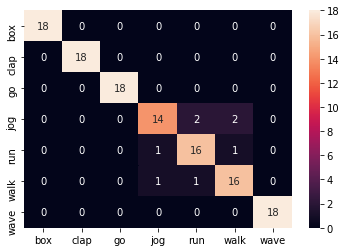

In [19]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# CSN

In [3]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth \
      -O checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth

--2021-03-28 21:54:04--  https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119580180 (114M) [application/octet-stream]
Saving to: ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’

checkpoints/ircsn_i 100%[===================>] 114,04M  7,32MB/s    in 18s     

2021-03-28 21:54:27 (6,46 MB/s) - ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’ saved [119580180/119580180]



In [12]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [13]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-csn'

cfg.train_pipeline[1] = dict(type='RawFrameDecode')
cfg.test_pipeline[1] = dict(type='RawFrameDecode')
cfg.val_pipeline[1] = dict(type='RawFrameDecode')

cfg.train_pipeline[7].input_format = 'NCHW_Flow'
cfg.test_pipeline[6].input_format = 'NCHW_Flow'
cfg.val_pipeline[6].input_format = 'NCHW_Flow'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 25

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
dataset_type = 'RawframeDataset'
data_root = 'data/childact_rawframe/train/'
data_root_val = 'data/childact_rawframe/val/'
ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'
img_norm_cfg = dict(
 

In [14]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-29 00:08:15,510 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-03-29 00:08:15,511 - mmaction - INFO - Use load_from_http loader
2021-03-29 00:08:15,830 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-03-29 00:08:15,831 - mmaction - INFO - Use load_from_local loader
2021-03-29 00:08:15,981 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-29 00:08:15,983 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /ho

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/base.py", line 280, in __getitem__
    return self.prepare_train_frames(idx)
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/rawframe_dataset.py", line 170, in prepare_train_frames
    return self.pipeline(results)
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/pipelines/compose.py", line 41, in __call__
    data = t(data)
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/pipelines/augmentations.py", line 1243, in __call__
    assert self.mean.shape[0] == 2
AssertionError


In [16]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [17]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.1 task/s, elapsed: 120s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9365
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9365
top1_acc: 0.9365
top5_acc: 1.0000
mean_class_accuracy: 0.9365


<AxesSubplot:>

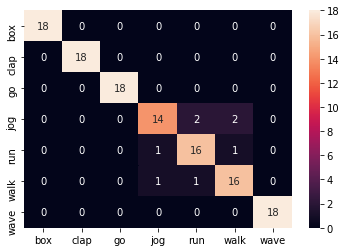

In [19]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# TANet

In [1]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tanet/tanet_r50_dense_1x1x8_100e_kinetics400_rgb/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth \
      -O checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth

--2021-03-29 00:29:51--  https://download.openmmlab.com/mmaction/recognition/tanet/tanet_r50_dense_1x1x8_100e_kinetics400_rgb/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102681749 (98M) [application/octet-stream]
Saving to: ‘checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth’

checkpoints/tanet_r 100%[===================>]  97,92M  11,1MB/s    in 9,1s    

2021-03-29 00:30:03 (10,8 MB/s) - ‘checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth’ saved [102681749/102681749]



In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tanet/tanet_r50_dense_1x1x8_100e_kinetics400_rgb.py')

In [3]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-TANet'

# cfg.train_pipeline[1] = dict(type='RawFrameDecode')
# cfg.test_pipeline[1] = dict(type='RawFrameDecode')
# cfg.val_pipeline[1] = dict(type='RawFrameDecode')

# cfg.train_pipeline[7].input_format = 'NCHW_Flow'
# cfg.test_pipeline[6].input_format = 'NCHW_Flow'
# cfg.val_pipeline[6].input_format = 'NCHW_Flow'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 25

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.img_norm_cfg.mean = [0.485, 0.456, 0.406]
cfg.img_norm_cfg.std = [0.229, 0.224, 0.225]

cfg.train_pipeline[6] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
cfg.test_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
cfg.val_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='TANet',
        pretrained='torchvision://resnet50',
        depth=50,
        num_segments=8,
        tam_cfg=dict()),
    cls_head=dict(
        type='TSMHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.5,
        init_std=0.001),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=12)
log_config = dict(interval=25, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset'
data_root = 'data/childact_rawframe/train/'
data_root_val = 'data/childact_rawframe/val/'
ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
ann_file_val = 'data/child

In [4]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-29 01:12:21,182 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.bias', 'fc.weight'}


Use load_from_torchvision loader


2021-03-29 01:12:23,634 - mmaction - INFO - load checkpoint from checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth
2021-03-29 01:12:23,635 - mmaction - INFO - Use load_from_local loader
2021-03-29 01:12:23,774 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-29 01:12:23,775 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-TANet
2021-03-29 01:12:23,776 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarn

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/base.py", line 280, in __getitem__
    return self.prepare_train_frames(idx)
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/rawframe_dataset.py", line 170, in prepare_train_frames
    return self.pipeline(results)
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/pipelines/compose.py", line 41, in __call__
    data = t(data)
  File "/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/datasets/pipelines/augmentations.py", line 1243, in __call__
    assert self.mean.shape[0] == 2
AssertionError


In [16]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [17]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.1 task/s, elapsed: 120s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9365
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9365
top1_acc: 0.9365
top5_acc: 1.0000
mean_class_accuracy: 0.9365


<AxesSubplot:>

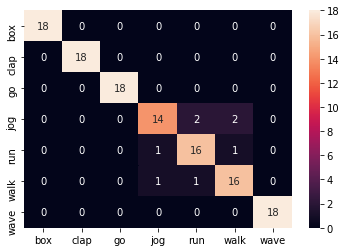

In [19]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )